In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Original Training Data Distribution:
Training_Program
0    26
2    24
3    22
1    21
4    18
5    18
6    12
7    11
Name: count, dtype: int64

Training Data Distribution After SMOTE:
Training_Program
7    26
1    26
2    26
4    26
6    26
3    26
5    26
0    26
Name: count, dtype: int64
Fitting 2 folds for each of 50 candidates, totalling 100 fits


C:\Users\licop\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters for Logistic Regression: {'solver': 'saga', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.75      0.60      0.67         5
           2       0.33      0.33      0.33         6
           3       0.29      0.33      0.31         6
           4       0.25      0.20      0.22         5
           5       0.29      0.50      0.36         4
           6       0.50      0.67      0.57         3
           7       0.50      0.33      0.40         3

    accuracy                           0.44        39
   macro avg       0.46      0.44      0.44        39
weighted avg       0.47      0.44      0.44        39

Test Accuracy: 0.44


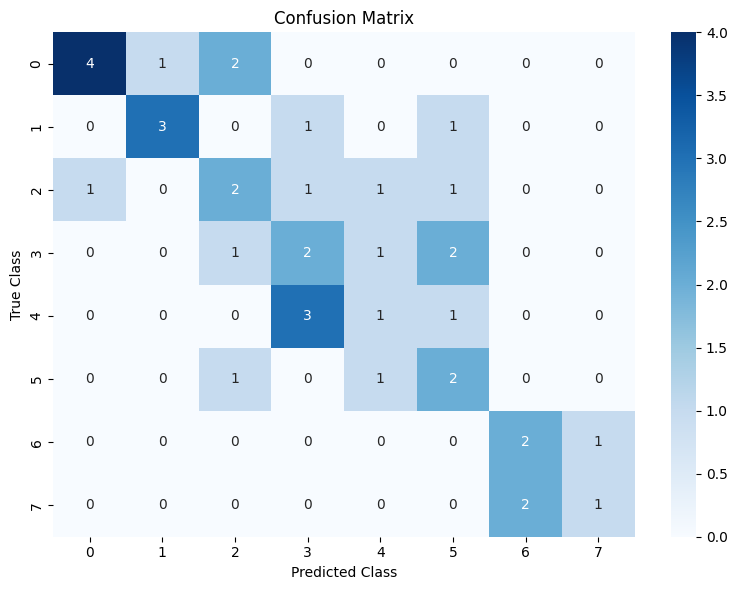

Logistic Regression Feature Importances:
              Feature  Importance
5   sports_experience    6.745780
10     W/Height_Ratio    2.398375
17        upper_leg_c    1.598780
18          lower_leg    1.490268
16              hip_c    1.378040
15            waist_c    1.281683
6            body_fat    1.160485
4       resting_pulse    1.118906
0              gender    0.949845
1              height    0.662309
3                 age    0.602150
11         shoulder_c    0.433208
14         left_arm_c    0.358601
2              weight    0.345542
9         W/Hip_Ratio    0.340922
7               goals    0.297807
12            chest_c    0.106714
13        right_arm_c    0.106097
8                 BMI    0.085017


C:\Users\licop\AppData\Local\Temp\ipykernel_8920\1662810318.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=log_importances, x='Importance', y='Feature', palette='coolwarm')


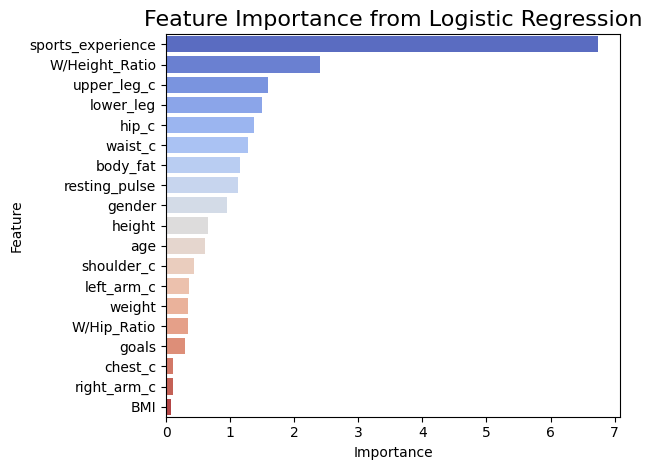

In [30]:
# Load the dataset
VT = pd.read_csv("data/processed_VT_Data.csv")
pd.set_option('display.max_columns', None)

# Separate features and target variable
X = VT.drop(columns=["Training_Program", "surgeries", "chronic_conditions"])
y = VT["Training_Program"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

# Normalize the data\
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Generate synthetic data with SMOTE
smote = SMOTE(random_state=12)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Training Data Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTraining Data Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Define the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=12)

# Define hyperparameters for optimization
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'multi_class': ['ovr', 'multinomial'],
    'class_weight': [None, 'balanced']
}

# Perform Randomized Search with Cross-Validation
random_search_logreg = RandomizedSearchCV(
    estimator=logreg_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=2,
    random_state=12,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search_logreg.fit(X_train_resampled, y_train_resampled)

# Best parameters and model performance
print("Best Parameters for Logistic Regression:", random_search_logreg.best_params_)

# Get the best estimator from RandomizedSearchCV
best_logreg = random_search_logreg.best_estimator_

# Predict on the test data
y_pred = best_logreg.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_logreg.classes_, yticklabels=best_logreg.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Extract feature importances (coefficients) from the best model
log_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(best_logreg.coef_[0])  # Absolute value of coefficients
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Logistic Regression Feature Importances:")
print(log_importances)

# Plot feature importance
sns.barplot(data=log_importances, x='Importance', y='Feature', palette='coolwarm')
plt.title('Feature Importance from Logistic Regression', fontsize=16)
plt.tight_layout()
plt.show()